# ***Classification Project***

Bu proje, sınıflandırma algoritmalarını kullanacağınız ilk projeniz. Bu projede, lojistik regresyon yöntemini kullanarak bir sınıflandırma problemini çözmeniz beklenmektedir. Projede uygulamanız gereken adımlar şunlar:

- ilgi alanınıza göre bir veri kümesi seçin
- araştırma sorusu belirleme
- veri temizliği
- veri keşfi
- özellik mühendisliği
- test kümesi oluşturma
- ilk sınıflandırma modeli
- modeli kullanarak tahmin yapma
 
Yukarıdaki adımları tamamladıktan sonra, araştırma sorunuza hangi cevapları bulduğunuzu açıklayin Vardığınız sonuçları sebepleriyle beraber tartışin.

---

## ***Titanic***

- Siniflandirma projesinde Titanic verileriyle calisarak faciada hayatta kalma durumunu tahmin edecegiz. Titanic verileri [Kaggle](https://www.kaggle.com/c/titanic/data)'dan elde edilmisitir. Buradaki ```train.csv``` dosyası kullanilmistir.
- ***Veri Seti:*** Titanic
- ***Arastirma konusu:*** Faciadan kurtulma durumu hedef degisken, diger degiskenler aciklayici degisken olmak uzere faciadan kurtulma durumunu tahmin eden bir model olusturulacaktir.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
# classifiers, regressors
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
import xgboost as xgb
# pipeline meta model
from sklearn.pipeline import Pipeline
# olceklendirme
from sklearn.preprocessing import StandardScaler
# polinom ozellikler
from sklearn.preprocessing import PolynomialFeatures
# egitim verisini ayirma
from sklearn.model_selection import train_test_split
# metrics
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# cross validation
from sklearn.model_selection import cross_validate, cross_val_score
# hiperparametre tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# uyarilari dikkate alma
import warnings
warnings.filterwarnings('ignore')

# pandas varsayilan olarak cok sayida sutun veya satir varsa tumunu gostermez
# bu nedenle 100 sutun ve satir gostermesi icin
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# virgulden sonra belirli sayida basamak gosterimi icin 
pd.options.display.float_format = '{:,.3f}'.format
# aciklama sutunun tam cikmasi icin
pd.options.display.max_colwidth = 100

# font tanimlamalari
title_font = {'family': 'times new roman', 'color': 'darkred', 
              'weight': 'bold', 'size': 14}
axis_font  = {'family': 'times new roman', 'color': 'darkred', 
              'weight': 'bold', 'size': 14}

---
### ***Veri Kesfi***
- Veri setini inceleme.

In [2]:
# veri setini dataframe icerisine yukle
titanic = pd.read_csv('data/titanic_train.csv')

titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- Cabin, Ticket degiskenleri numerik olmadigindan ve burada ihtiyacimiz olmadigindan cikarabiliriz.

In [3]:
titanic = titanic.drop(['Cabin','Ticket'], axis=1)

In [4]:
titanic['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

- Embarked 3 farkli deger almis, eksik veriler en sik karsilasilan degerle doldurulabilir.

In [5]:
titanic['Embarked'] = titanic['Embarked'].fillna('S')

In [6]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 69.7+ KB


***Cinsiyet ve Liman bilgisi encode edilerek dahil edildi***

In [7]:
# get_dummies metodu ile encode edilir
titanic = pd.concat([titanic, pd.get_dummies(titanic.Sex, 
                                             drop_first=True)], axis=1)
titanic = pd.concat([titanic, pd.get_dummies(titanic.Embarked, 
                                             drop_first=True, prefix='Embarked')], axis=1)
# encode edilen sutunlar drop edilir

In [8]:
titanic.drop(['Sex', 'Embarked'], axis=1, inplace=True)

- Name sutunundan title bilgisi extract edildi.

In [9]:
titanic.Name.head(10)

0                                Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Thayer)
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
5                                       Moran, Mr. James
6                                McCarthy, Mr. Timothy J
7                         Palsson, Master. Gosta Leonard
8      Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                    Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [10]:
def add_title(col):
    if 'Mrs' in col:
        return 'mrs'
    elif 'Master' in col:
        return 'master'
    elif 'Mr' in col:
        return 'mr'
    elif 'Miss' in col:
        return 'miss'
    else:
        return 'no_title'

In [11]:
add_title('Fortune, Mr. Charles Alexander')

'mr'

In [12]:
titanic['title'] = titanic['Name'].apply(add_title)

In [13]:
titanic['title'].unique()

array(['mr', 'mrs', 'miss', 'master', 'no_title'], dtype=object)

In [14]:
titanic = pd.concat([titanic,pd.get_dummies(titanic['title'])], axis=1)

In [15]:
titanic

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Fare,male,Embarked_Q,Embarked_S,title,master,miss,mr,mrs,no_title
0,1,0,3,"Braund, Mr. Owen Harris",22.000,1,0,7.250,1,0,1,mr,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",38.000,1,0,71.283,0,0,0,mrs,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26.000,0,0,7.925,0,0,1,miss,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.000,1,0,53.100,0,0,1,mrs,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",35.000,0,0,8.050,1,0,1,mr,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",27.000,0,0,13.000,1,0,1,no_title,0,0,0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",19.000,0,0,30.000,0,0,1,miss,0,1,0,0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",nan,1,2,23.450,0,0,1,miss,0,1,0,0,0
889,890,1,1,"Behr, Mr. Karl Howell",26.000,0,0,30.000,1,0,0,mr,0,0,1,0,0


In [16]:
titanic.drop(['Name', 'title', 'no_title'], axis=1, inplace=True)

- Son olarak yas degerindeki nan degerler icin model olusturularak tahmin yapilacak.

In [17]:
# diger bir yontem yas sutunundaki eksik degerleri ortalama ile doldurmak
# titanic['Age'].fillna(np.floor(titanic['Age'].mean()), inplace=True)

In [18]:
titanic

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Embarked_Q,Embarked_S,master,miss,mr,mrs
0,1,0,3,22.000,1,0,7.250,1,0,1,0,0,1,0
1,2,1,1,38.000,1,0,71.283,0,0,0,0,0,0,1
2,3,1,3,26.000,0,0,7.925,0,0,1,0,1,0,0
3,4,1,1,35.000,1,0,53.100,0,0,1,0,0,0,1
4,5,0,3,35.000,0,0,8.050,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000,0,0,13.000,1,0,1,0,0,0,0
887,888,1,1,19.000,0,0,30.000,0,0,1,0,1,0,0
888,889,0,3,nan,1,2,23.450,0,0,1,0,1,0,0
889,890,1,1,26.000,0,0,30.000,1,0,0,0,0,1,0


---
### ***Yas Sutunundaki Eksik Degerleri Tahmin Ile Doldurma***

In [19]:
# yas degerleri dolu ve bos olan sample lar ayri ayri alinir
titanic_w_age = titanic[titanic['Age'].notnull()]
titanic_no_age = titanic[titanic['Age'].isnull()]

In [20]:
titanic_w_age

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Embarked_Q,Embarked_S,master,miss,mr,mrs
0,1,0,3,22.000,1,0,7.250,1,0,1,0,0,1,0
1,2,1,1,38.000,1,0,71.283,0,0,0,0,0,0,1
2,3,1,3,26.000,0,0,7.925,0,0,1,0,1,0,0
3,4,1,1,35.000,1,0,53.100,0,0,1,0,0,0,1
4,5,0,3,35.000,0,0,8.050,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,886,0,3,39.000,0,5,29.125,0,1,0,0,0,0,1
886,887,0,2,27.000,0,0,13.000,1,0,1,0,0,0,0
887,888,1,1,19.000,0,0,30.000,0,0,1,0,1,0,0
889,890,1,1,26.000,0,0,30.000,1,0,0,0,0,1,0


#### ***Model - Pipeline***
Meta model olarak dusunulebilecek pipeline sinifi ile modelleri test ederek en iyi performans veren modeli sececegiz.

In [21]:
# hedef degisken
y = titanic_w_age['Age']
# aciklayici degiskenler
X = titanic_w_age.drop(['PassengerId', 'Age'], axis=1)

In [22]:
%%time
# egitim ve test kumesini ayirma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

CPU times: user 14.5 ms, sys: 178 µs, total: 14.7 ms
Wall time: 12.9 ms


In [23]:
%%time
# hucrenin calisma suresini tutacak

# pipeline tanimla
# ilk model knn ve preprocessing yapilmayacak 
pipe = Pipeline([('preprocessing', None), ('regressor', KNeighborsRegressor())])

# aranacak model ve parametreleri belirle
param_grid = [{'regressor': [KNeighborsRegressor()], 'preprocessing': [None],
               'regressor__n_neighbors': np.arange(3,10),
               'regressor__weights': ['uniform', 'distance']},
              {'regressor': [LinearRegression()], 'preprocessing': [None]},
              {'regressor': [Ridge()], 'preprocessing': [None],
               'regressor__alpha': np.logspace(-3,3,7)},
              {'regressor': [Lasso()], 'preprocessing': [None],
               'regressor__alpha': np.logspace(-3,3,7)},
              {'regressor': [DecisionTreeRegressor()], 'preprocessing': [None],
               'regressor__max_depth': np.arange(3,10)},              
              {'regressor': [RandomForestRegressor()], 'preprocessing': [None],
               'regressor__max_depth': np.arange(3,10)},
              {'regressor': [SVR()], 'preprocessing': [StandardScaler(), None],
               'regressor__gamma': np.logspace(-3,2,6),
               'regressor__C': np.logspace(-3,2,6)},
              {'regressor': [SVR(kernel='linear')], 'preprocessing': [StandardScaler(), None],
               'regressor__C': np.logspace(-3,2,6)},
              {'regressor': [XGBRegressor()], 'preprocessing': [None],
               'regressor__gamma': np.logspace(-3,2,6),
               'regressor__reg_alpha': np.logspace(-3,2,6), 
               'regressor__reg_lambda': np.logspace(-3,2,6), 
               'regressor__max_depth': np.arange(3,10)},
              {'regressor': [LGBMRegressor()], 'preprocessing': [None],
               'regressor__reg_alpha': np.logspace(-3,2,6), 
               'regressor__reg_lambda': np.logspace(-3,2,6), 
               'regressor__max_depth': np.arange(3,10)}              
             ]
# gridsearch nesnesi tanimla
grid = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=['neg_root_mean_squared_error','r2'], 
                    cv=7, n_jobs=-1, return_train_score=True, refit='neg_root_mean_squared_error')
# modeli egit
grid.fit(X_train, y_train)

# sonuclar
print("Best params: \n{}\n".format(grid.best_params_))
print("Best cross-validation score: \n{:.2f}\n".format(grid.best_score_))
print("Test-set score: \n{:.2f}\n".format(grid.score(X_test, y_test)))


Best params: 
{'preprocessing': None, 'regressor': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False), 'regressor__max_depth': 4}

Best cross-validation score: 
-10.92

Test-set score: 
-11.15

CPU times: user 1min 17s, sys: 1.57 s, total: 1min 19s
Wall time: 5min 55s


In [24]:
# sonuclari df olarak kaydet
grid_df = pd.DataFrame(grid.cv_results_)
grid_df.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing,param_regressor,param_regressor__n_neighbors,param_regressor__weights,param_regressor__alpha,param_regressor__max_depth,param_regressor__C,param_regressor__gamma,param_regressor__reg_alpha,param_regressor__reg_lambda,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,split5_test_neg_root_mean_squared_error,split6_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,split5_train_neg_root_mean_squared_error,split6_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,split5_test_r2,split6_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,split5_train_r2,split6_train_r2,mean_train_r2,std_train_r2
0,0.013,0.009,0.007,0.001,None,"KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',\n met...",3,uniform,NaN,NaN,NaN,NaN,NaN,NaN,"{'preprocessing': None, 'regressor': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric=...",-13.495,-12.357,-14.125,-13.241,-13.694,-12.918,-13.418,-13.321,0.524,1829,-10.247,-10.193,-9.977,-10.370,-10.154,-9.899,-10.102,-10.135,0.148,0.122,0.161,0.027,0.057,0.244,0.147,0.238,0.142,0.076,1821,0.500,0.514,0.527,0.497,0.494,0.538,0.502,0.510,0.016


In [25]:
# sirala
grid_df = grid_df.sort_values(by='mean_test_neg_root_mean_squared_error', ascending=False)
# ilk siradakileri goster
grid_df.loc[:,['param_regressor','mean_train_neg_root_mean_squared_error',
               'mean_test_neg_root_mean_squared_error','mean_train_r2','mean_test_r2']].head(12)

,param_regressor,mean_train_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_train_r2,mean_test_r2
37,"RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',\n max...",-10.322,-10.921,0.492,0.424
1691,"LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,\n impo...",-9.514,-10.936,0.569,0.423
1685,"LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,\n impo...",-9.513,-10.944,0.569,0.422
1679,"LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,\n impo...",-9.513,-10.946,0.569,0.422
1672,"LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,\n impo...",-10.506,-10.951,0.474,0.421
1703,"LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,\n impo...",-9.578,-10.957,0.563,0.421
1671,"LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,\n impo...",-10.511,-10.960,0.473,0.420
1669,"LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,\n impo...",-10.514,-10.961,0.473,0.420
1670,"LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,\n impo...",-10.514,-10.961,0.473,0.420
1739,"LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,\n impo...",-9.366,-10.964,0.582,0.420


In [26]:
# secilen modeli olustur ve test et
lgbm_reg = LGBMRegressor(max_depth=4, reg_alpha=0.1, reg_lambda=10)
lgbm_reg.fit(X_train, y_train)
y_pred = lgbm_reg.predict(X_test)
# degerleri yuvarla
y_pred = np.around(y_pred)
print('rmse : {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

rmse : 11.15


In [27]:
# secilen modeli butun veriyle egitip tahmin degerleri ile eksik degerleri doldur
lgbm_reg = LGBMRegressor(max_depth=4, reg_alpha=0.1, reg_lambda=10)
lgbm_reg.fit(X, y)
# eksik degerlerin aciklayici degiskenler bolumu
X_fill = titanic_no_age.drop(['PassengerId', 'Age'], axis=1)
# eksik degerleri  tahmin ile doldur
predicted_age = lgbm_reg.predict(X_fill)
# degerleri incele
predicted_age[:10]

array([32.89591762, 31.29562167, 27.12868865, 28.51492777, 20.68348996,
       28.75733132, 35.27054275, 24.81742161, 21.22301958, 28.4411498 ])

In [28]:
# degerleri yuvarlayarak doldur
titanic_no_age['Age'] = np.around(predicted_age)

In [29]:
# ayirdigimiz dfleri birlestir
titanic = pd.concat([titanic_w_age, titanic_no_age])

In [30]:
# sirala
titanic = titanic.sort_values(by='PassengerId')

In [31]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Age          891 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   male         891 non-null    uint8  
 8   Embarked_Q   891 non-null    uint8  
 9   Embarked_S   891 non-null    uint8  
 10  master       891 non-null    uint8  
 11  miss         891 non-null    uint8  
 12  mr           891 non-null    uint8  
 13  mrs          891 non-null    uint8  
dtypes: float64(2), int64(5), uint8(7)
memory usage: 61.8 KB


---
### ***Kurtulma Tahmin Modeli - Pipeline***
Meta model olarak dusunulebilecek pipeline sinifi ile modelleri test ederek en iyi performans veren modeli sececegiz.

In [52]:
# hedef degisken
y = titanic['Survived']
# aciklayici degiskenler
X = titanic.drop(['PassengerId', 'Survived'], axis=1)

In [53]:
# egitim ve test kumesini ayirma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [54]:
%%time
# hucrenin calisma suresini tutacak

# pipeline tanimla
# ilk model knn ve preprocessing dahil tanimlandi 
pipe = Pipeline([('preprocessing', None), 
                 ('classifier', KNeighborsClassifier())])

# aranacak model ve parametreleri belirle
param_grid = [{'classifier': [KNeighborsClassifier()], 'preprocessing': [None],
               'classifier__n_neighbors': np.arange(3,10),
               'classifier__weights': ['uniform', 'distance']},
              {'classifier': [LogisticRegression()], 'preprocessing': [None],
               'classifier__C': np.logspace(-3,2,6)},
              {'classifier': [LogisticRegression(solver='liblinear')], 'preprocessing': [None],
               'classifier__penalty': ['l1', 'l2'],
               'classifier__C': np.logspace(-3,2,6)},
              {'classifier': [DecisionTreeClassifier()], 'preprocessing': [None],
               'classifier__max_depth': np.arange(3,10)},
              {'classifier': [RandomForestClassifier()], 'preprocessing': [None],
               'classifier__max_depth': np.arange(3,10)},
              {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
               'classifier__gamma': np.logspace(-3,2,6),
               'classifier__C': np.logspace(-3,2,6)},
              {'classifier': [SVC(kernel='linear')], 'preprocessing': [StandardScaler(), None],
               'classifier__C': np.logspace(-3,2,6)},
              {'classifier': [XGBClassifier()], 'preprocessing': [None],
               'classifier__gamma': np.logspace(-3,2,6),
               'classifier__reg_alpha': np.logspace(-3,2,6), 
               'classifier__reg_lambda': np.logspace(-3,2,6), 
               'classifier__max_depth': np.arange(3,10)},
              {'classifier': [LGBMClassifier()], 'preprocessing': [None],
               'classifier__reg_alpha': np.logspace(-3,2,6), 
               'classifier__reg_lambda': np.logspace(-3,2,6), 
               'classifier__max_depth': np.arange(3,10)}
             ]
# gridsearch nesnesi tanimla
grid_survive = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=['roc_auc','f1','accuracy'], 
                            cv=7, n_jobs=-1, return_train_score=True, refit='accuracy')
# modeli egit
grid_survive.fit(X_train, y_train)

# sonuclar
print("Best params: \n{}\n".format(grid_survive.best_params_))
print("Best cross-validation score: \n{:.2f}\n".format(grid_survive.best_score_))
print("Test-set score: \n{:.2f}\n".format(grid_survive.score(X_test, y_test)))


Best params: 
{'classifier': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=1.0,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=6,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=None, reg_alpha=1.0,
              reg_lambda=0.1, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=False, verbosity=None), 'classifier__gamma': 1.0, 'classifier__max_depth': 6, 'classifier__reg_alpha': 1.0, 'classifier__reg_lambda': 0.1, 'preprocessing': None}

Best cross-validation score: 
0.85

Test-set score: 
0.84

CPU times: user 1min 32s, sys: 1.77 s, total: 1min 34s
Wall time: 7min 22s


In [55]:
# sonuclari df olarak kaydet
grid_survive_df = pd.DataFrame(grid_survive.cv_results_)
grid_survive_df.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__n_neighbors,param_classifier__weights,param_preprocessing,param_classifier__C,param_classifier__penalty,param_classifier__max_depth,param_classifier__gamma,param_classifier__reg_alpha,param_classifier__reg_lambda,params,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,split5_test_roc_auc,split6_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,split5_train_roc_auc,split6_train_roc_auc,mean_train_roc_auc,std_train_roc_auc,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,split5_test_f1,split6_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,split3_train_f1,split4_train_f1,split5_train_f1,split6_train_f1,mean_train_f1,std_train_f1,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,split5_test_accuracy,split6_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,split5_train_accuracy,split6_train_accuracy,mean_train_accuracy,std_train_accuracy
0,0.008,0.000,0.023,0.002,"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',\n m...",3,uniform,None,NaN,NaN,NaN,NaN,NaN,NaN,"{'classifier': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', ...",0.729,0.699,0.779,0.668,0.758,0.748,0.783,0.737,0.039,1755,0.921,0.922,0.913,0.920,0.913,0.917,0.915,0.917,0.004,0.575,0.580,0.611,0.533,0.613,0.613,0.650,0.597,0.035,1326,0.776,0.785,0.763,0.777,0.761,0.769,0.774,0.772,0.008,0.696,0.716,0.725,0.657,0.716,0.713,0.723,0.706,0.022,1326,0.838,0.844,0.828,0.839,0.828,0.835,0.838,0.836,0.006


In [56]:
# sirala
grid_survive_df = grid_survive_df.sort_values(by='mean_test_accuracy', ascending=False)
# ilk siradakileri goster
grid_survive_df.loc[:,['param_classifier','mean_train_accuracy', 'mean_test_accuracy', 'mean_train_roc_auc',
                       'mean_test_roc_auc','mean_train_f1','mean_test_f1']].head(5)

,param_classifier,mean_train_accuracy,mean_test_accuracy,mean_train_roc_auc,mean_test_roc_auc,mean_train_f1,mean_test_f1
1049,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_by...",0.900,0.854,0.963,0.884,0.860,0.797
1014,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_by...",0.896,0.854,0.958,0.881,0.854,0.795
764,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_by...",0.905,0.853,0.971,0.886,0.870,0.794
656,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_by...",0.888,0.851,0.947,0.883,0.845,0.795
1048,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_by...",0.901,0.851,0.964,0.885,0.861,0.792


In [57]:
# her bir classifier in en iyi degerleriyle ayri bir df olustur
best_of_classifiers = pd.DataFrame([])
for classifier in grid_survive_df.param_classifier.unique():
    best_of_classifiers = pd.concat([best_of_classifiers,grid_survive_df[grid_survive_df['param_classifier']==classifier].head(1)])

In [65]:
best_of_classifiers

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__n_neighbors,param_classifier__weights,param_preprocessing,param_classifier__C,param_classifier__penalty,param_classifier__max_depth,param_classifier__gamma,param_classifier__reg_alpha,param_classifier__reg_lambda,params,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,split5_test_roc_auc,split6_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,split5_train_roc_auc,split6_train_roc_auc,mean_train_roc_auc,std_train_roc_auc,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,split5_test_f1,split6_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,split3_train_f1,split4_train_f1,split5_train_f1,split6_train_f1,mean_train_f1,std_train_f1,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,split5_test_accuracy,split6_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,split5_train_accuracy,split6_train_accuracy,mean_train_accuracy,std_train_accuracy
1049,0.182,0.025,0.009,0.001,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_by...",NaN,NaN,None,NaN,NaN,7,1.000,1.000,0.010,"{'classifier': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, ...",0.875,0.902,0.901,0.850,0.875,0.887,0.896,0.884,0.017,94,0.964,0.966,0.955,0.967,0.955,0.966,0.965,0.963,0.005,0.767,0.816,0.817,0.805,0.732,0.817,0.822,0.797,0.031,1,0.867,0.868,0.847,0.866,0.860,0.853,0.860,0.860,0.007,0.833,0.863,0.873,0.853,0.814,0.871,0.871,0.854,0.021,1,0.903,0.905,0.890,0.903,0.900,0.895,0.900,0.900,0.005
1843,0.129,0.020,0.030,0.008,"LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,\n im...",NaN,NaN,None,NaN,NaN,8,NaN,1.000,1.000,"{'classifier': LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0, ...",0.875,0.899,0.888,0.849,0.879,0.878,0.910,0.883,0.018,120,0.967,0.965,0.965,0.968,0.968,0.972,0.965,0.967,0.002,0.757,0.795,0.795,0.816,0.743,0.789,0.822,0.788,0.027,19,0.871,0.874,0.864,0.881,0.860,0.855,0.864,0.867,0.008,0.824,0.853,0.853,0.863,0.824,0.851,0.871,0.848,0.017,15,0.905,0.908,0.902,0.913,0.900,0.895,0.902,0.904,0.005
96,0.034,0.002,0.013,0.001,"SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,\n decision_functio...",NaN,NaN,"StandardScaler(copy=True, with_mean=True, with_std=True)",10.000,NaN,NaN,0.010,NaN,NaN,"{'classifier': SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0, de...",0.832,0.858,0.918,0.833,0.844,0.855,0.889,0.861,0.029,830,0.891,0.894,0.885,0.896,0.883,0.874,0.883,0.886,0.007,0.737,0.778,0.800,0.750,0.767,0.776,0.842,0.779,0.032,138,0.787,0.774,0.771,0.778,0.782,0.779,0.769,0.777,0.006,0.804,0.843,0.853,0.804,0.833,0.851,0.881,0.839,0.026,150,0.846,0.833,0.833,0.839,0.841,0.836,0.833,0.837,0.005
44,0.376,0.023,0.052,0.003,"RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,\n ...",NaN,NaN,None,NaN,NaN,8,NaN,NaN,NaN,"{'classifier': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None, ...",0.847,0.889,0.914,0.829,0.848,0.898,0.895,0.874,0.030,511,0.975,0.971,0.972,0.972,0.974,0.972,0.970,0.972,0.001,0.753,0.784,0.800,0.769,0.750,0.765,0.795,0.774,0.018,275,0.884,0.903,0.872,0.898,0.883,0.881,0.886,0.887,0.010,0.814,0.843,0.863,0.824,0.824,0.842,0.851,0.837,0.016,254,0.918,0.930,0.910,0.926,0.918,0.915,0.920,0.919,0.006
33,0.013,0.007,0.018,0.009,"DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',\n ...",NaN,NaN,None,NaN,NaN,4,NaN,NaN,NaN,"{'classifier': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini

In [69]:
best_of_classifiers.loc[29,:]['params']

{'classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                    warm_start=False),
 'classifier__C': 10.0,
 'classifier__penalty': 'l2',
 'preprocessing': None}

In [91]:
# adlandirma olmali, grafik gosterimi icin
name_list = []
for i in best_of_classifiers.index:
    classifier = best_of_classifiers.loc[i,'param_classifier']
    name = classifier.__class__.__name__    
    if (name == 'SVC'):
        name = name + '_' + classifier.kernel
    elif (name == 'LogisticRegression'):
        name = name.split('ression')[0]
        name = name + '_' + classifier.solver
    else:
        name = name.split('assifier')[0]
        
    name_list.append(name)

print(name_list)

['XGBCl', 'LGBMCl', 'SVC_rbf', 'RandomForestCl', 'DecisionTreeCl', 'SVC_linear', 'LogisticReg_liblinear', 'LogisticReg_lbfgs', 'KNeighborsCl']


In [92]:
# adlandirma olmali, grafik gosterimi icin
best_of_classifiers['classifier'] = name_list

In [93]:
# her bir classifier in skor degerlerini incele
best_of_classifiers.loc[:,['classifier','mean_train_accuracy', 'mean_test_accuracy','mean_train_roc_auc',
                       'mean_test_roc_auc','mean_train_f1','mean_test_f1']]

,classifier,mean_train_accuracy,mean_test_accuracy,mean_train_roc_auc,mean_test_roc_auc,mean_train_f1,mean_test_f1
1049,XGBCl,0.900,0.854,0.963,0.884,0.860,0.797
1843,LGBMCl,0.904,0.848,0.967,0.883,0.867,0.788
96,SVC_rbf,0.837,0.839,0.886,0.861,0.777,0.779
44,RandomForestCl,0.919,0.837,0.972,0.874,0.887,0.774
33,DecisionTreeCl,0.857,0.834,0.900,0.867,0.808,0.775
128,SVC_linear,0.833,0.829,0.859,0.853,0.772,0.767
29,LogisticReg_liblinear,0.835,0.827,0.876,0.870,0.776,0.766
18,LogisticReg_lbfgs,0.828,0.827,0.875,0.869,0.768,0.766
4,KNeighborsCl,0.808,0.715,0.883,0.739,0.731,0.603


***Grafik Incelemesi***

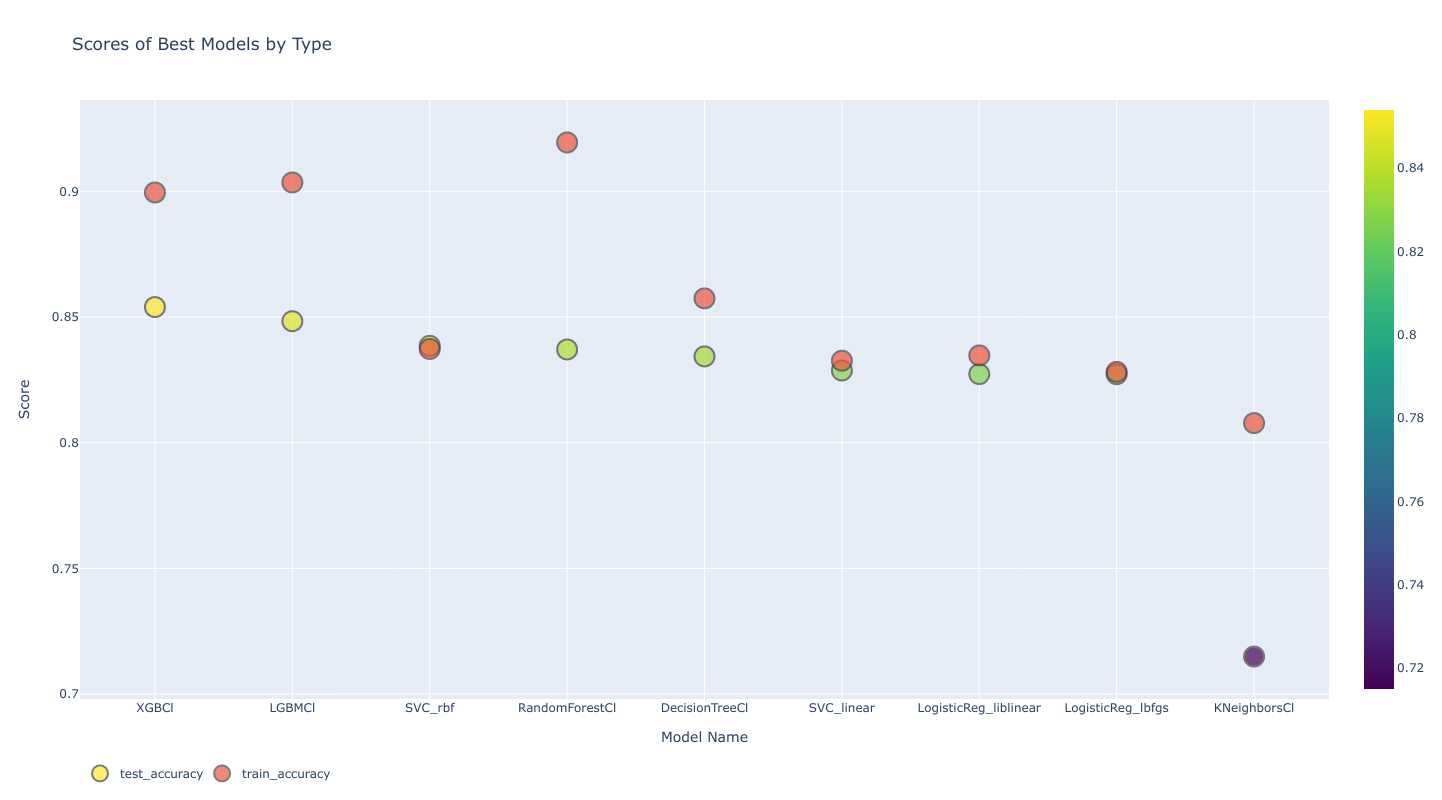

In [119]:
#fig = px.scatter(best_of_classifiers, x="classifier", y="mean_test_accuracy", color="classifier",
#                 size='mean_test_roc_auc', hover_data=['mean_test_accuracy','mean_test_roc_auc', 'mean_test_f1'])
fig = go.Figure()
fig.add_trace(go.Scatter(x=best_of_classifiers['classifier'], 
                         y=best_of_classifiers['mean_test_accuracy'],
                         name='test_accuracy', marker=dict(color=best_of_classifiers['mean_test_accuracy'] ,
                                                           colorscale='Viridis', showscale=True),
                         mode='markers', opacity=0.7))
fig.add_trace(go.Scatter(x=best_of_classifiers['classifier'], 
                         y=best_of_classifiers['mean_train_accuracy'],
                         name='train_accuracy', 
                         mode='markers', opacity=0.7))
# marker size belirle
fig.update_traces(mode='markers', marker_size=20, marker_line_width=2)
# layout degistir
fig.update_layout(title='Scores of Best Models by Type', legend_orientation="h",
                   xaxis_title='Model Name',
                   yaxis_title='Score', width=1300, height=800, )
fig.show()

***f1 ve auc skor hesaplama***

In [42]:
# secilen modeli olustur ve test et
xgb_cl = XGBClassifier(max_depth=5, reg_alpha=1, reg_lambda=1, gamma=0.01)
# modeli egit
xgb_cl.fit(X_train, y_train)
# tahmin olustur
y_pred = xgb_cl.predict(X_test)
# auc score hesaplamada olasilik gerekli
y_pred_prob = xgb_cl.predict_proba(X_test)
print('f1 score  : {:.2f}'.format(f1_score(y_test, y_pred))) 
# auc score da predict prob nin 1 inci sutunu yani survive olma durumunu aliriz
print('auc score : {:.2f}'.format(roc_auc_score(y_test, y_pred_prob[:,1])))

f1 score  : 0.80
auc score : 0.92


***classsification_report***

In [43]:
print('classification report : \n{}'.format(classification_report(y_test, y_pred)))

classification report : 
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       110
           1       0.85      0.75      0.80        69

    accuracy                           0.85       179
   macro avg       0.85      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179



***cross_val_score***

In [44]:
# modeli yeniden olustur
xgb_cl = XGBClassifier(max_depth=5, reg_alpha=1, reg_lambda=1, gamma=0.01)
# cross_val_score ile skor sonucunu al
cv_auc = cross_val_score(estimator=xgb_cl, X=X, y=y, cv=10, scoring='roc_auc')
# cv skorlarinin ortalamasi
print('cv auc score mean: {:.2f}'.format(cv_auc.mean()))

cv auc score mean: 0.89


***feature_importances_***

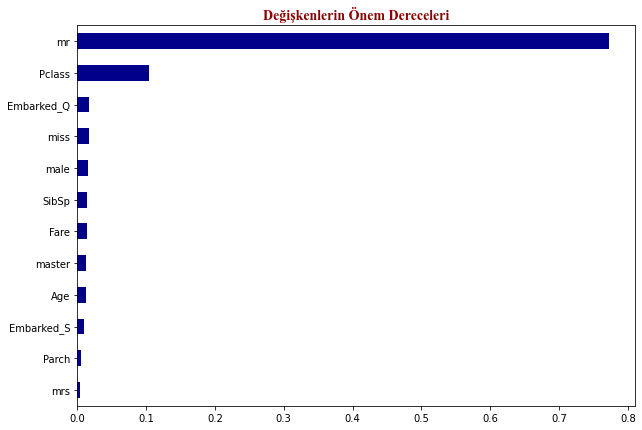

In [45]:
# ozellik oneminden once model fit edilmeli
xgb_cl.fit(X_train, y_train)
# ozellik onem dereceleri
# onem derecelerinden seri olustur
önem_dereceleri = pd.Series(data=xgb_cl.feature_importances_,index= X_train.columns)
# sirala
önem_dereceleri_sıralı = önem_dereceleri.sort_values()
# grafigini ciz
plt.figure(figsize=(10,7))
önem_dereceleri_sıralı.plot(kind='barh', color='darkblue')
plt.title('Değişkenlerin Önem Dereceleri', fontdict=title_font)
plt.show()

***Native API ile AUC score hesaplama***

In [46]:
# dmatrix donusturme, xgboost performans ve etkinligini bu veri yapisindan alir
dmatrix_train = xgb.DMatrix(data=X_train, label=y_train)
# predict ederken de dmatrix veri yapisi kullanacagiz
dmatrix_X_test = xgb.DMatrix(data=X_test)

In [47]:
# parametereler en iyi sonuc verenler secildi
params = {"objective":"binary:logistic", "max_depth":5, 
          'reg_lambda': 1 , 'reg_alpha': 1, 'gamma': 0.01, "silent":1}

In [48]:
# modeli egit
xgb_cl_dmatrix = xgb.train(params=params, dtrain=dmatrix_train, num_boost_round=100)

In [49]:
# tahmin yap
y_pred_dmatrix = xgb_cl_dmatrix.predict(data=dmatrix_X_test)

In [50]:
# tahmin sonuclari olasilik degerleridir, 
# bu degerler skor hesaplama icin tahmin degerlerine donusturulebilir
# 0.5 den buyukse True degilse False
y_pred = y_pred_dmatrix>0.5

In [51]:
# f1 skoru tahmin degerleri ile hesapladik
print('f1 score  : {:.2f}'.format(f1_score(y_test, y_pred)))
# roc_auc skorunu tahmin olasiliklari ile hesapladik
print('auc score : {:.2f}'.format(roc_auc_score(y_test, y_pred_dmatrix)))

f1 score  : 0.80
auc score : 0.92
